#**PROBLEMA DE NEGOCIO**


---




La urgencia por detectar fraudes en transacciones móviles de dinero ha llevado a una empresa del segmento Fintech a buscar soluciones innovadoras. Como científicos de datos hemos sido convocados para desarrollar un modelo de machine learning que pueda distinguir de manera precisa entre transacciones legítimas y fraudulentas, estableciendo así un estándar de seguridad en el sector financiero móvil global.

### **Tus tareas principales serán:**

**1. Preprocesamiento de Datos:** Realizar limpieza de datos, manejar valores faltantes, codificación de variables categóricas y normalización/escalado de datos.

**2. Exploración de Datos:** Analizar y comprender el conjunto de datos proporcionado, identificar variables llaves y realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning como Regresión Logística, Árboles de Decisión, Random Forest, Naive Bayes, entre otros.

**4. Evaluación y Selección del Modelo:** Evaluar los modelos utilizando métricas como precisión, recall, área bajo la curva ROC, y F1-score. Seleccionar el modelo con el mejor rendimiento para la detección de transacciones bancarias fraudulentas.

#**1. Configuración del Ambiente**


---




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [58]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
!pip install -U imbalanced-learn
!pip install ydata-profiling
!pip install pyspark
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
global df_banco, resultados

#1.1 Prueba de carga de datos BIG

In [ ]:
!pip install -q kaggle


Se buscó el comando de la API del dataset en Kaggle

In [ ]:
!kaggle datasets download -d ealaxi/paysim1


Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
100% 178M/178M [00:07<00:00, 31.9MB/s]
100% 178M/178M [00:07<00:00, 26.4MB/s]


SE realiza la descopresión del archivo

In [ ]:
!unzip paysim1.zip


Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


Una vez descomprimido , se visualiza como dataframe, exploramos y luego guardamos como csv.

In [ ]:
# Asegúrate de usar la ruta correcta al archivo CSV
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto_Financial_Fraud_Detection_/paysm1.csv', index=False)

#**2. Preprocesamiento de Datos**


---


In [ ]:
# df_banco = pd.read_csv("https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/fraud_dataset_example.csv")
# df_banco.head()
df_banco = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Proyecto_Financial_Fraud_Detection_/paysm1.csv")
df=df_banco.copy()

In [ ]:
total_nulos = df.isnull().sum().sum()
print(total_nulos)

0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


#Función Procesar_datos BIG

In [28]:
#@title
def procesar_datos():

  global df_banco,   type2 , dataframe
  df_banco = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Proyecto_Financial_Fraud_Detection_/paysm1.csv")
  df=df_banco.copy()
  # Crea la nueva columna 'type2'
  df['type2'] =df.apply(lambda row: row['nameOrig'][0] + row['nameDest'][0], axis=1)

    # Aplicar get_dummies a las columnas 'type' y 'type2'
  # Lista de columnas a eliminar
  columnas_a_eliminar = ['type','type2','nameOrig', 'nameDest', 'isFlaggedFraud', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

  dummies = pd.get_dummies(df[['type', 'type2']], drop_first=False)

  # Concatenar el DataFrame original con las columnas dummies
  df = pd.concat([df, dummies], axis=1)

  df= df.drop(columns=columnas_a_eliminar)

  # Lista de columnas booleanas
  columnas_booleanas = ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'type2_CC', 'type2_CM']

  # Cambiar los valores booleanos a 0 y 1
  for columna in columnas_booleanas:
      df[columna] = df[columna].astype(int)




        # Cambiar tipos de datos
  df = df.astype({
      'step': 'int16',
      'amount': 'float32',
      'isFraud': 'int8',
      'type_CASH_IN': 'int8',
      'type_CASH_OUT': 'int8',
      'type_DEBIT': 'int8',
      'type_PAYMENT': 'int8',
      'type_TRANSFER': 'int8',
      'type2_CC': 'int8',
      'type2_CM': 'int8'
  })

  # # Imprimir el consumo de memoria antes y después de la optimización
  # print("Consumo de memoria antes de la optimización:", df.memory_usage().sum() / (1024 * 1024), "MB")
  # print("Consumo de memoria después de la optimización:", df_opt.memory_usage().sum() / (1024 * 1024), "MB")

  return df


#Función Procesar_datos Muestra

In [3]:
#@title
def procesar_datos_muestra():

  global df_banco, df
  df_banco = pd.read_csv("https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/fraud_dataset_example.csv")
  df=df_banco.copy()
  # Crea la nueva columna 'type2'
  df['type2'] =df.apply(lambda row: row['nameOrig'][0] + row['nameDest'][0], axis=1)

    # Aplicar get_dummies a las columnas 'type' y 'type2'
  # Lista de columnas a eliminar
  columnas_a_eliminar = ['type','type2','nameOrig', 'nameDest', 'isFlaggedFraud', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

  dummies = pd.get_dummies(df[['type', 'type2']], drop_first=False)

  # Concatenar el DataFrame original con las columnas dummies
  df = pd.concat([df, dummies], axis=1)

  df= df.drop(columns=columnas_a_eliminar)

  # Lista de columnas booleanas
  columnas_booleanas = ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'type2_CC', 'type2_CM']

  # Cambiar los valores booleanos a 0 y 1
  for columna in columnas_booleanas:
      df[columna] = df[columna].astype(int)

  # Cambiar tipos de datos
  df = df.astype({
      'step': 'int16',
      'amount': 'float64',
      'isFraud': 'int8',
      'type_CASH_IN': 'int8',
      'type_CASH_OUT': 'int8',
      'type_DEBIT': 'int8',
      'type_PAYMENT': 'int8',
      'type_TRANSFER': 'int8',
      'type2_CC': 'int8',
      'type2_CM': 'int8'
  })

  # # Imprimir el consumo de memoria antes y después de la optimización
  # print("Consumo de memoria antes de la optimización:", df.memory_usage().sum() / (1024 * 1024), "MB")
  # print("Consumo de memoria después de la optimización:", df_opt.memory_usage().sum() / (1024 * 1024), "MB")

  return df

#Desarrollo de preprocesamiento

In [ ]:
# # Asegúrate de que las columnas 'nameOrig' y 'nameDest' sean de tipo string
# df['nameOrig'] = df['nameOrig'].astype(str)
# df['nameDest'] = df['nameDest'].astype(str)

# Crea la nueva columna 'type2'
df['type2'] =df.apply(lambda row: row['nameOrig'][0] + row['nameDest'][0], axis=1)


In [ ]:
print("\nElemento unicos en 'type':")
print(df['type'].unique())
print("-------------------")
print("\nElemento unicos en 'type2':")
print(df['type2'].unique())


Elemento unicos en 'type':
['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
-------------------

Elemento unicos en 'type2':
['CM' 'CC']


##Verificar duplicados

In [ ]:
df_duplicados = df[df.duplicated(keep=False)]

print("\nDataFrame con los duplicados:")
print(df_duplicados)


DataFrame con los duplicados:
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud, type2]
Index: []


##Get_dummies

In [ ]:
# Aplicar get_dummies a las columnas 'type' y 'type2'
# Lista de columnas a eliminar
columnas_a_eliminar = ['type','type2','nameOrig', 'nameDest', 'isFlaggedFraud', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

dummies = pd.get_dummies(df[['type', 'type2']], drop_first=False)

# Concatenar el DataFrame original con las columnas dummies
df = pd.concat([df, dummies], axis=1)

df= df.drop(columns=columnas_a_eliminar)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   step           int64  
 1   amount         float64
 2   isFraud        int64  
 3   type_CASH_IN   bool   
 4   type_CASH_OUT  bool   
 5   type_DEBIT     bool   
 6   type_PAYMENT   bool   
 7   type_TRANSFER  bool   
 8   type2_CC       bool   
 9   type2_CM       bool   
dtypes: bool(7), float64(1), int64(2)
memory usage: 188.1 MB


##Transformando booleanos a enteros

In [ ]:
# Lista de columnas booleanas
columnas_booleanas = ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'type2_CC', 'type2_CM']

# Cambiar los valores booleanos a 0 y 1
for columna in columnas_booleanas:
    df[columna] = df[columna].astype(int)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   step           int64  
 1   amount         float64
 2   isFraud        int64  
 3   type_CASH_IN   int64  
 4   type_CASH_OUT  int64  
 5   type_DEBIT     int64  
 6   type_PAYMENT   int64  
 7   type_TRANSFER  int64  
 8   type2_CC       int64  
 9   type2_CM       int64  
dtypes: float64(1), int64(9)
memory usage: 485.4 MB


##Nueva verificación de duplicados

In [ ]:
df_duplicados = df[df.duplicated(keep=False)]

print("\nDataFrame con los duplicados:")
print(df_duplicados)


DataFrame con los duplicados:
         step       amount  isFraud  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
1062        1       663.34        0             0              0           0   
1543        1       663.34        0             0              0           0   
4532        4       354.75        0             0              0           0   
4768        4       354.75        0             0              0           0   
7619        7      5238.34        0             0              0           0   
...       ...          ...      ...           ...            ...         ...   
6362579   741  10000000.00        1             0              1           0   
6362580   741  10000000.00        1             0              0           0   
6362581   741  10000000.00        1             0              1           0   
6362582   741  10000000.00        1             0              0           0   
6362583   741  10000000.00        1             0              1           0   

        

In [ ]:
df_duplicados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12101 entries, 1062 to 6362583
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   step           12101 non-null  int64  
 1   amount         12101 non-null  float64
 2   isFraud        12101 non-null  int64  
 3   type_CASH_IN   12101 non-null  int64  
 4   type_CASH_OUT  12101 non-null  int64  
 5   type_DEBIT     12101 non-null  int64  
 6   type_PAYMENT   12101 non-null  int64  
 7   type_TRANSFER  12101 non-null  int64  
 8   type2_CC       12101 non-null  int64  
 9   type2_CM       12101 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 1.0 MB


In [ ]:
df_duplicados.describe()

step        amount       isFraud  type_CASH_IN  type_CASH_OUT  \
count  12101.000000  1.210100e+04  12101.000000  12101.000000   12101.000000   
mean     242.468887  2.559983e+06      0.013635      0.048591       0.065366   
std      121.634253  4.346774e+06      0.115976      0.215020       0.247182   
min        1.000000  0.000000e+00      0.000000      0.000000       0.000000   
25%      166.000000  4.247330e+03      0.000000      0.000000       0.000000   
50%      278.000000  1.047971e+04      0.000000      0.000000       0.000000   
75%      321.000000  1.000000e+07      0.000000      0.000000       0.000000   
max      741.000000  1.000000e+07      1.000000      1.000000       1.000000   

         type_DEBIT  type_PAYMENT  type_TRANSFER      type2_CC      type2_CM  
count  12101.000000  12101.000000   12101.000000  12101.000000  12101.000000  
mean       0.000661      0.636394       0.248988      0.363606      0.636394  
std        0.025704      0.481057       0.432445      0.481057      0.481057  
min        0.000000      0.000000       0.000000      0.000000      0.000000  
25%        0.000000      0.000000       0.000000      0.000000      0.000000  
50%        0.000000      1.000000       0.000000      0.000000      1.000000  
75%        0.000000      1.000000       0.000000      1.000000      1.000000  
max        1.000000      1.000000       1.000000      1.000000      1.000000

In [ ]:
df_duplicados[df_duplicados['step']==1]

step  amount  isFraud  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
1062     1  663.34        0             0              0           0   
1543     1  663.34        0             0              0           0   

      type_PAYMENT  type_TRANSFER  type2_CC  type2_CM  
1062             1              0         0         1  
1543             1              0         0         1

In [ ]:
df_banco[df_banco['amount']==663.34]

step     type  amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
1062        1  PAYMENT  663.34   C948960194     1347260.94      1346597.60   
1543        1  PAYMENT  663.34  C1691858720       54727.71        54064.37   
6017586   451  PAYMENT  663.34   C903013820        5149.00         4485.66   

           nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
1062     M173060252             0.0             0.0        0               0  
1543     M807872790             0.0             0.0        0               0  
6017586  M127272212             0.0             0.0        0               0

In [ ]:
df_banco[df_banco['amount']==354.75]

step     type  amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
4532        4  PAYMENT  354.75  C1233246555       310005.5       309650.74   
4768        4  PAYMENT  354.75  C1079152956       105744.0       105389.25   
4369674   310  PAYMENT  354.75  C1478890200       203277.0       202922.25   

            nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
4532     M1701331644             0.0             0.0        0               0  
4768      M161237395             0.0             0.0        0               0  
4369674  M2026728635             0.0             0.0        0               0

In [ ]:
df_banco[df_banco['amount']==5238.34]

step     type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
7619        7  PAYMENT  5238.34  C1174829684        20454.0        15215.66   
9091        7  PAYMENT  5238.34   C622702995            0.0            0.00   
521458     20  PAYMENT  5238.34   C849194284       136265.0       131026.66   
1977515   178  PAYMENT  5238.34   C592771366         1051.0            0.00   
5435137   378  PAYMENT  5238.34  C1682972821            0.0            0.00   

            nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
7619      M757515938             0.0             0.0        0               0  
9091      M278894001             0.0             0.0        0               0  
521458    M572163236             0.0             0.0        0               0  
1977515  M1553609225             0.0             0.0        0               0  
5435137   M669799814             0.0             0.0        0               0

Eliminar duplicados
Luego de la verificiación del set de datos original, no hay registros que cumplan con la condición de duplicados. A continuación se realizará la exploración de datos y el balanceo optimo para iniciar con el modelo de clasificación.

#Carga de base de datos con función procesar datos

In [5]:
df=procesar_datos_muestra()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   step           101613 non-null  int16  
 1   amount         101613 non-null  float64
 2   isFraud        101613 non-null  int8   
 3   type_CASH_IN   101613 non-null  int8   
 4   type_CASH_OUT  101613 non-null  int8   
 5   type_DEBIT     101613 non-null  int8   
 6   type_PAYMENT   101613 non-null  int8   
 7   type_TRANSFER  101613 non-null  int8   
 8   type2_CC       101613 non-null  int8   
 9   type2_CM       101613 non-null  int8   
dtypes: float64(1), int16(1), int8(8)
memory usage: 1.7 MB


In [7]:
df['amount'].describe()

count    1.016130e+05
mean     1.740901e+05
std      3.450199e+05
min      3.200000e-01
25%      1.001659e+04
50%      5.338541e+04
75%      2.124984e+05
max      1.000000e+07
Name: amount, dtype: float64

#**3. Exploración de Datos**


---


##Descripción Original de los datos

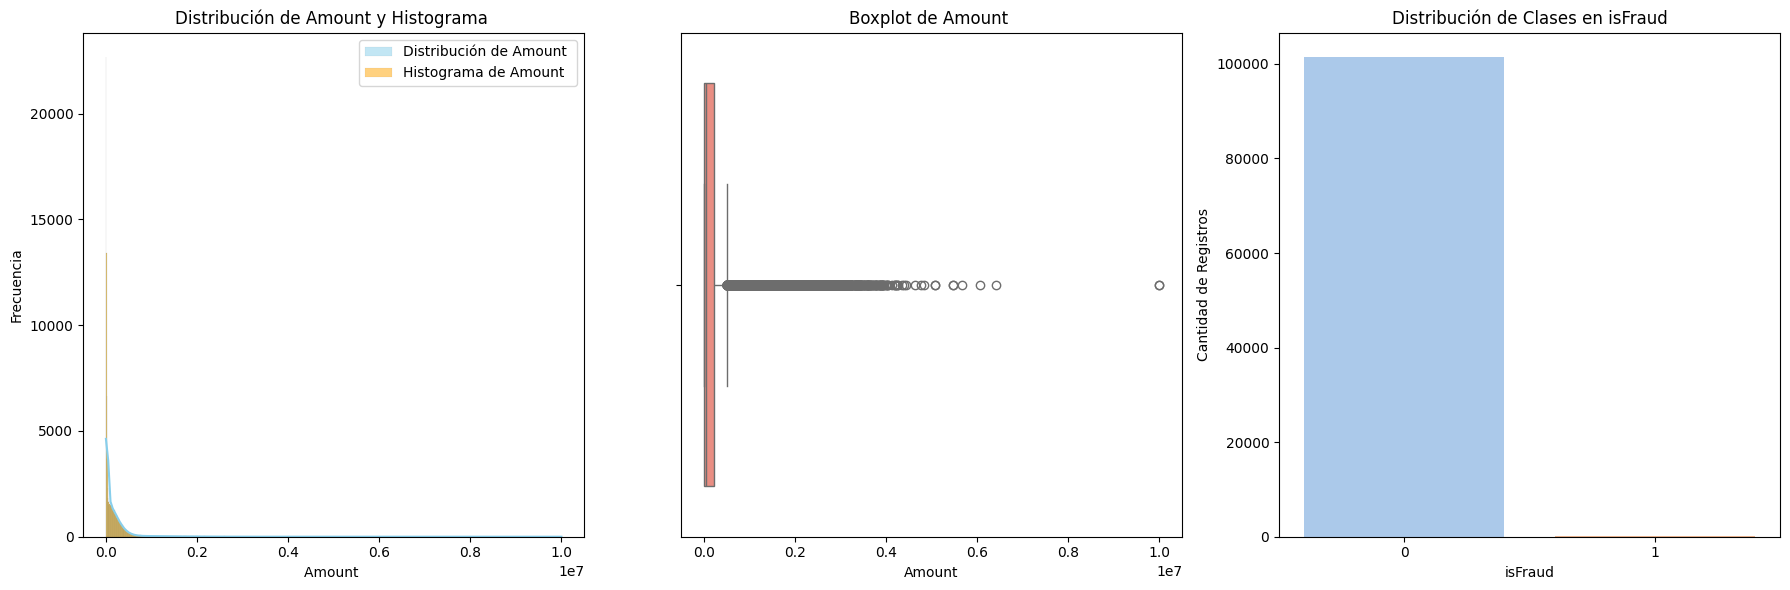

In [8]:
# Crear figura y ejes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))



# Graficar la distribución de 'amount' escalado
sns.histplot(data=df, x='amount', kde=True, ax=axes[0], color='skyblue', label='Distribución de Amount ')
sns.histplot(data=df, x='amount', kde=False, ax=axes[0], color='orange', alpha=0.5, label='Histograma de Amount ')

# Configuración del primer gráfico
axes[0].set_title('Distribución de Amount y Histograma ')
axes[0].set_xlabel('Amount ')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# Graficar el boxplot de 'amount' en horizontal
sns.boxplot(data=df, x='amount', ax=axes[1], color='salmon')
axes[1].set_title('Boxplot de Amount ')
axes[1].set_xlabel('Amount')


# Graficar la distribución de clases en 'isFraud'
sns.countplot(data=df, x='isFraud', ax=axes[2], palette='pastel')
axes[2].set_title('Distribución de Clases en isFraud')
axes[2].set_xlabel('isFraud')
axes[2].set_ylabel('Cantidad de Registros')

plt.tight_layout()
plt.show()

##Matriz de correlación de Spearman

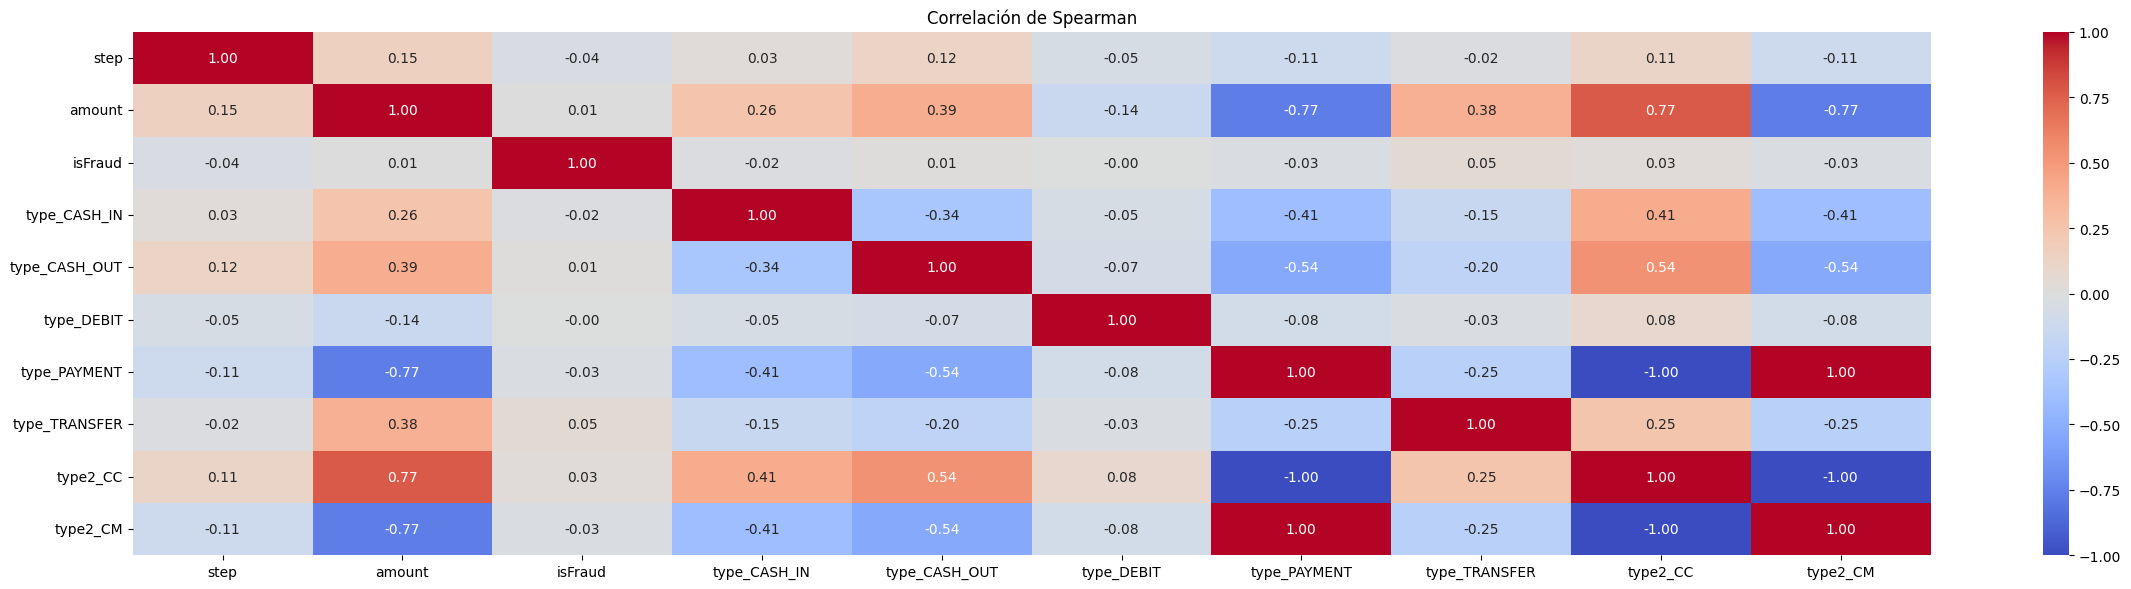

In [20]:
# Crear figura y ejes
fig, axes = plt.subplots(figsize=(24, 6))

# Calcula la matriz de correlación de Spearman
corr_spearman = df.corr(method='spearman')

# Graficar la matriz de correlación de Spearman
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f")
axes.set_title('Correlación de Spearman')

plt.tight_layout()
plt.show()


##Visualización sin outliers

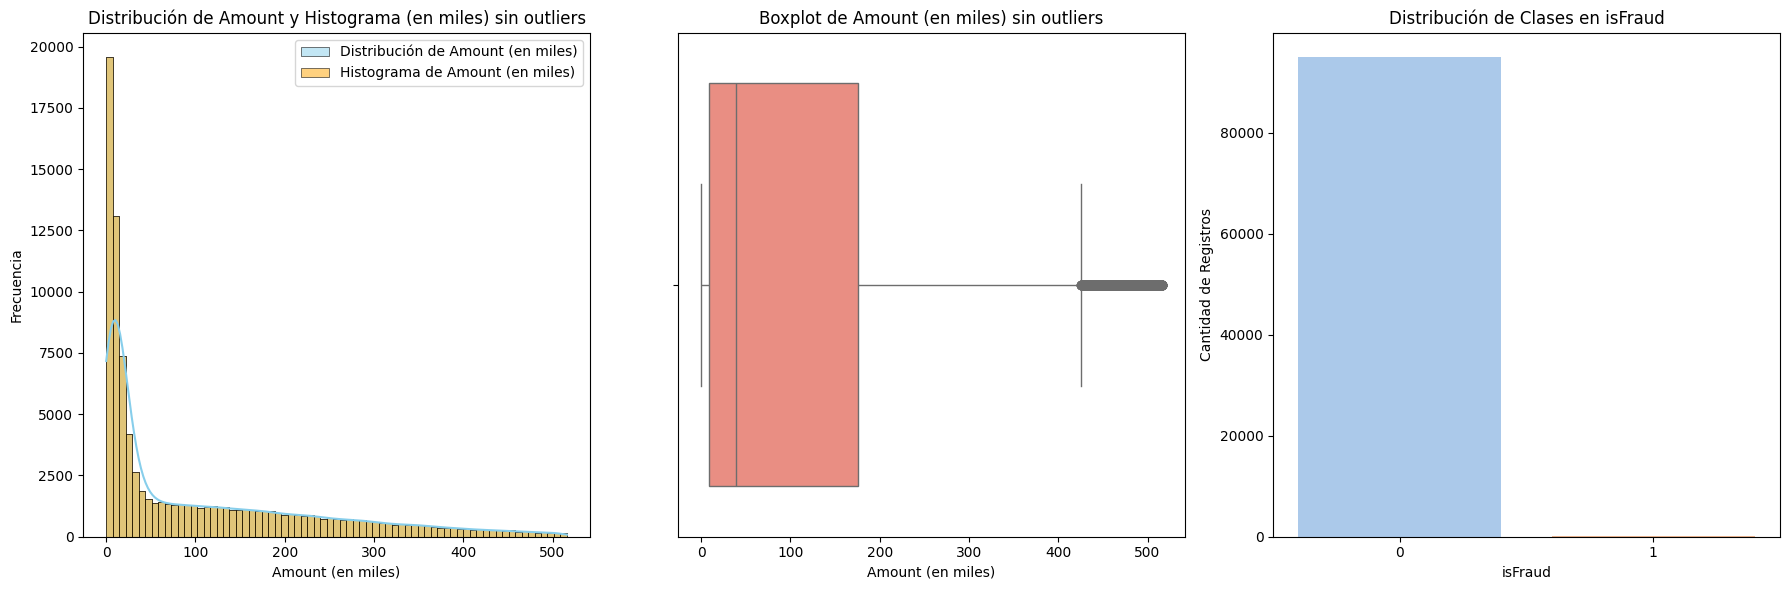

In [26]:
# Calcular el rango intercuartílico (IQR)
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites inferior y superior para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar outliers
df_filtered = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

# Crear figura y ejes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Escalar 'amount' para mostrar en miles
df_filtered['amount_scaled'] = df_filtered['amount'] / 1000

# Graficar la distribución de 'amount' escalado
sns.histplot(data=df_filtered, x='amount_scaled', kde=True, ax=axes[0], color='skyblue', label='Distribución de Amount (en miles)')
sns.histplot(data=df_filtered, x='amount_scaled', kde=False, ax=axes[0], color='orange', alpha=0.5, label='Histograma de Amount (en miles)')

# Configuración del primer gráfico
axes[0].set_title('Distribución de Amount y Histograma (en miles) sin outliers')
axes[0].set_xlabel('Amount (en miles)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# Graficar el boxplot de 'amount' en horizontal
sns.boxplot(data=df_filtered, x='amount_scaled', ax=axes[1], color='salmon')
axes[1].set_title('Boxplot de Amount (en miles) sin outliers')
axes[1].set_xlabel('Amount (en miles)')


# Graficar la distribución de clases en 'isFraud'
sns.countplot(data=df_filtered, x='isFraud', ax=axes[2], palette='pastel')
axes[2].set_title('Distribución de Clases en isFraud')
axes[2].set_xlabel('isFraud')
axes[2].set_ylabel('Cantidad de Registros')

plt.tight_layout()
plt.show()

In [22]:
df_filtered['isFraud'].value_counts()

isFraud
0    95050
1       96
Name: count, dtype: int64

In [24]:
df_filtered.describe()

step         amount       isFraud  type_CASH_IN  type_CASH_OUT  \
count  95146.000000   95146.000000  95146.000000  95146.000000   95146.000000   
mean       8.504751  105408.418536      0.001009      0.211170       0.317848   
std        1.840472  125822.262520      0.031749      0.408141       0.465643   
min        1.000000       0.320000      0.000000      0.000000       0.000000   
25%        8.000000    9208.055000      0.000000      0.000000       0.000000   
50%        9.000000   38748.100000      0.000000      0.000000       0.000000   
75%       10.000000  175887.292500      0.000000      0.000000       1.000000   
max       10.000000  516171.930000      1.000000      1.000000       1.000000   

         type_DEBIT  type_PAYMENT  type_TRANSFER      type2_CC      type2_CM  \
count  95146.000000  95146.000000   95146.000000  95146.000000  95146.000000   
mean       0.010636      0.421058       0.039287      0.578942      0.421058   
std        0.102583      0.493731       0.194278      0.493731      0.493731   
min        0.000000      0.000000       0.000000      0.000000      0.000000   
25%        0.000000      0.000000       0.000000      0.000000      0.000000   
50%        0.000000      0.000000       0.000000      1.000000      0.000000   
75%        0.000000      1.000000       0.000000      1.000000      1.000000   
max        1.000000      1.000000       1.000000      1.000000      1.000000   

       amount_scaled  
count   95146.000000  
mean      105.408419  
std       125.822263  
min         0.000320  
25%         9.208055  
50%        38.748100  
75%       175.887293  
max       516.171930

##SMOTE

In [39]:
def balanceo_clases(df_filtered):
    global df_banco, resultados
    # Separar las características y la variable objetivo
    X = df_filtered.drop(columns=['isFraud'])
    y = df_filtered['isFraud']

    # Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Aplicar SMOTE solo al conjunto de entrenamiento para evitar el sesgo
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Crear un nuevo DataFrame con las características y la variable objetivo balanceada
    df_balanced = pd.DataFrame(X_train_resampled, columns=X.columns)
    df_balanced['isFraud'] = y_train_resampled

    # Verificar las distribuciones de clases después de aplicar SMOTE
    print(y_train_resampled.value_counts())

    return df_balanced
#Nota importante:
#Estrategia de muestreo con SMOTE
# from imblearn.over_sampling import SMOTE

# # Supongamos que X_resampled y y_resampled son tus datos de características y etiquetas respectivamente

# # Define el ratio de balanceo deseado (por ejemplo, 0.5 para 50%)
# sampling_strategy = 0.5

# # Aplica SMOTE con el sampling_strategy personalizado
# smote = SMOTE(sampling_strategy=sampling_strategy)
#  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

##Aplicar funcion Balancear

In [33]:
df_balanced = balanceo_clases(df_filtered)
df_balanced.info()

isFraud
0    76037
1    76037
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152074 entries, 0 to 152073
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   step           152074 non-null  int16  
 1   amount         152074 non-null  float64
 2   type_CASH_IN   152074 non-null  int8   
 3   type_CASH_OUT  152074 non-null  int8   
 4   type_DEBIT     152074 non-null  int8   
 5   type_PAYMENT   152074 non-null  int8   
 6   type_TRANSFER  152074 non-null  int8   
 7   type2_CC       152074 non-null  int8   
 8   type2_CM       152074 non-null  int8   
 9   amount_scaled  152074 non-null  float64
 10  isFraud        152074 non-null  int8   
dtypes: float64(2), int16(1), int8(8)
memory usage: 3.8 MB


##Visualizar datos balanceados

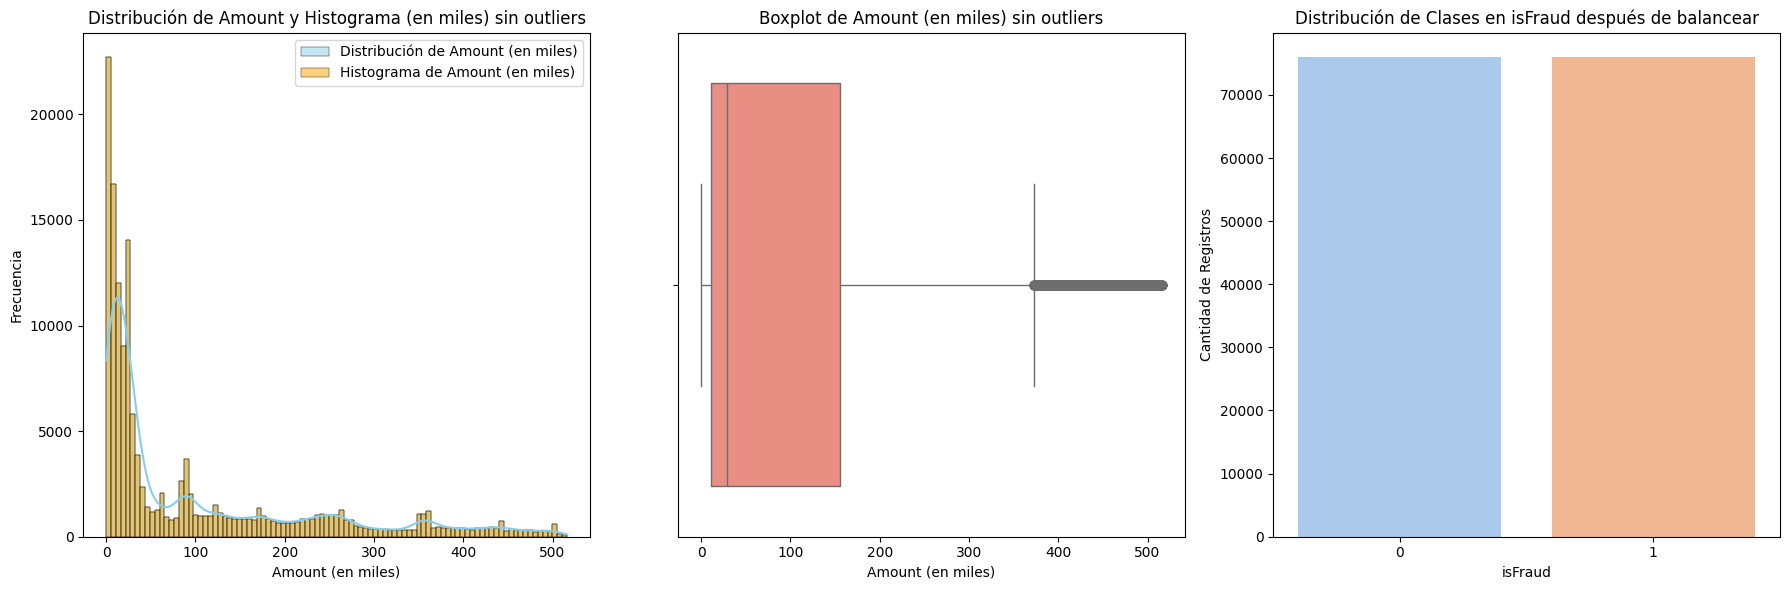

In [35]:
# Crear figura y ejes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Escalar 'amount' para mostrar en miles
df_balanced['amount_scaled'] = df_balanced['amount'] / 1000

# Graficar la distribución de 'amount' escalado
sns.histplot(data=df_balanced, x='amount_scaled', kde=True, ax=axes[0], color='skyblue', label='Distribución de Amount (en miles)')
sns.histplot(data=df_balanced, x='amount_scaled', kde=False, ax=axes[0], color='orange', alpha=0.5, label='Histograma de Amount (en miles)')

# Configuración del primer gráfico
axes[0].set_title('Distribución de Amount y Histograma (en miles) sin outliers')
axes[0].set_xlabel('Amount (en miles)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# Graficar el boxplot de 'amount' en horizontal
sns.boxplot(data=df_balanced, x='amount_scaled', ax=axes[1], color='salmon')
axes[1].set_title('Boxplot de Amount (en miles) sin outliers')
axes[1].set_xlabel('Amount (en miles)')

# Graficar la distribución de clases en 'isFraud' después de balancear
sns.countplot(data=df_balanced, x='isFraud', ax=axes[2], palette='pastel')
axes[2].set_title('Distribución de Clases en isFraud después de balancear')
axes[2].set_xlabel('isFraud')
axes[2].set_ylabel('Cantidad de Registros')

plt.tight_layout()
plt.show()



##Matriz de correlación datos balanceados

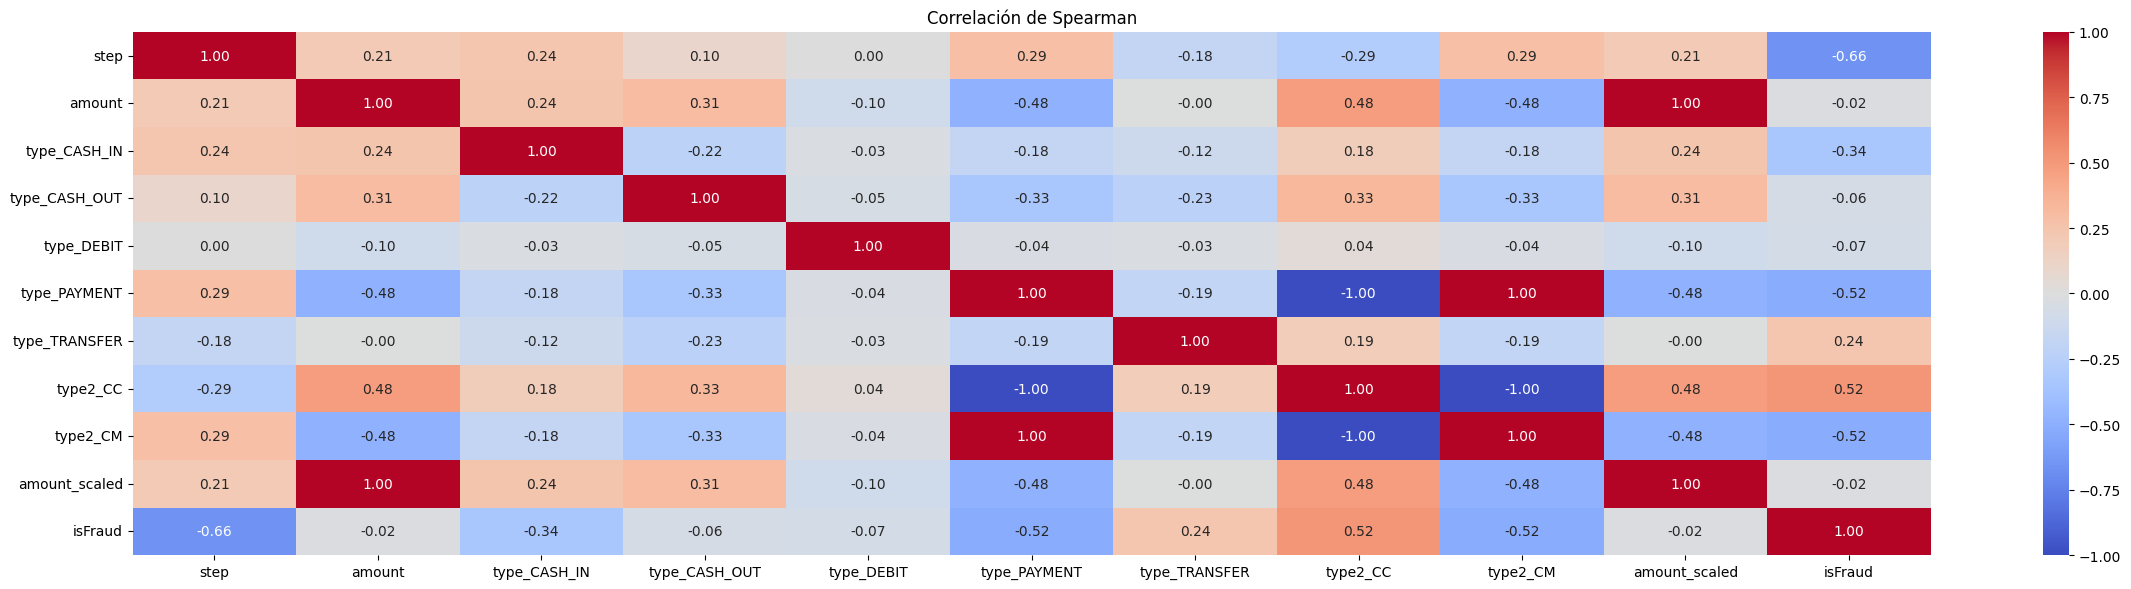

In [37]:
# Crear figura y ejes
fig, axes = plt.subplots(figsize=(24, 6))

# Calcula la matriz de correlación de Spearman
corr_spearman = df_balanced.corr(method='spearman')

# Graficar la matriz de correlación de Spearman
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f")
axes.set_title('Correlación de Spearman')

plt.tight_layout()
plt.show()


###exporación con pyspark

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

# Inicializa una sesión de Spark
spark = SparkSession.builder \
    .appName("VisualizaciónDatos") \
    .getOrCreate()

# Lee el archivo CSV
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Proyecto_Financial_Fraud_Detection_/paysm1.csv", header=True, inferSchema=True)

# Diagrama de cajas
df.select(df.columns[:9]).describe().toPandas().plot(kind='box', figsize=(12, 6))
plt.title('Diagrama de Cajas para Variables Numéricas')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.show()

# Distribución de cada variable
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns[:9]):
    plt.subplot(3, 3, i+1)
    df.select(col).toPandas().plot(kind='hist', ax=plt.gca(), title=f'Distribución de {col}', legend=False)
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Detén la sesión de Spark
spark.stop()


###ProfileReport

In [38]:
ProfileReport(df_balanced)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

###Pyspark

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

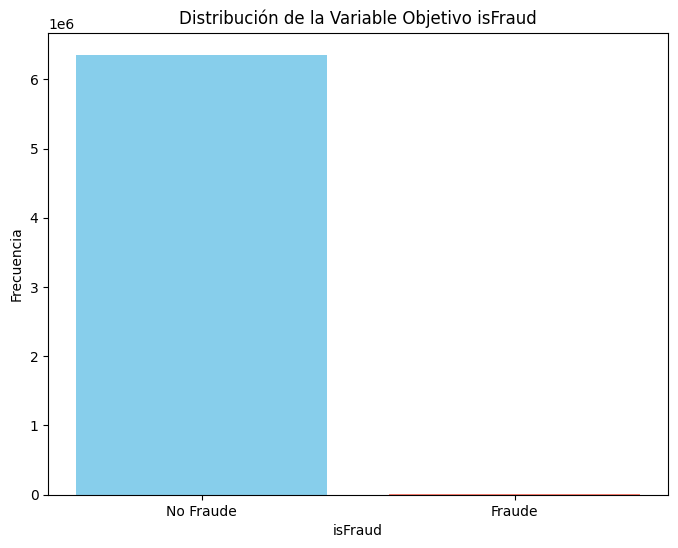

In [7]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Inicializa una sesión de Spark
spark = SparkSession.builder \
    .appName("VisualizaciónDatos") \
    .getOrCreate()

# Lee el archivo CSV
df_banco = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Proyecto_Financial_Fraud_Detection_/paysm1.csv", header=True, inferSchema=True)

# Muestra las primeras filas del DataFrame
df_banco.show()

# Calcula la distribución de la variable objetivo 'isFraud'
distribucion_clases = df_banco.groupBy('isFraud').count().orderBy('isFraud').collect()

# Extrae las clases y sus frecuencias
clases = [row['isFraud'] for row in distribucion_clases]
frecuencias = [row['count'] for row in distribucion_clases]

# Visualización de la distribución de clases
plt.figure(figsize=(8, 6))
plt.bar(clases, frecuencias, color=['skyblue', 'salmon'])
plt.title('Distribución de la Variable Objetivo isFraud')
plt.xlabel('isFraud')
plt.ylabel('Frecuencia')
plt.xticks(ticks=clases, labels=['No Fraude', 'Fraude'])
plt.show()

# Detén la sesión de Spark
spark.stop()


###Pyspark2

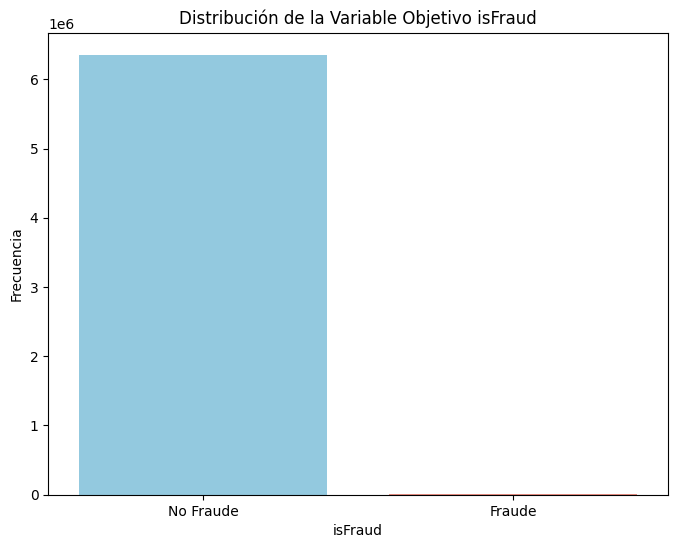

In [8]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

# Inicializa una sesión de Spark
spark = SparkSession.builder \
    .appName("VisualizaciónDatos") \
    .getOrCreate()

# Lee el archivo CSV
df_banco = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Proyecto_Financial_Fraud_Detection_/paysm1.csv", header=True, inferSchema=True)

# Calcula la distribución de la variable objetivo 'isFraud'
distribucion_clases = df_banco.groupBy('isFraud').count().orderBy('isFraud').collect()

# Extrae las clases y sus frecuencias
clases = [row['isFraud'] for row in distribucion_clases]
frecuencias = [row['count'] for row in distribucion_clases]

# Visualización de la distribución de clases con Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=clases, y=frecuencias, palette=['skyblue', 'salmon'])
plt.title('Distribución de la Variable Objetivo isFraud')
plt.xlabel('isFraud')
plt.ylabel('Frecuencia')
plt.xticks(ticks=clases, labels=['No Fraude', 'Fraude'])
plt.show()

# Detén la sesión de Spark
spark.stop()


balancear datos

In [ ]:
from imblearn.over_sampling import SMOTE

# Tu DataFrame
df1 = dfbigclean.copy()

# Separar características (features) y etiquetas (labels)
X = df1.drop('isFraud', axis=1)
y = df1['isFraud']


# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Crear un nuevo DataFrame balanceado
balanced_df = pd.concat([pd.DataFrame(X_balanced), pd.DataFrame(y_balanced, columns=['isFraud'])], axis=1)

# Verificar el balance de las clases
print(balanced_df['isFraud'].value_counts())



isFraud
0    6346920
1    6346920
Name: count, dtype: int64


balancear datos 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Supongamos que df es tu DataFrame original
# Supongamos también que ya tienes tus datos divididos en características (X) y etiquetas (y)

# Visualización de la distribución original de la clase isFraud
plt.figure(figsize=(8, 6))
df['isFraud'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución Original de la Clase isFraud')
plt.xlabel('isFraud')
plt.ylabel('Número de muestras')
plt.xticks(ticks=[0, 1], labels=['No Fraude', 'Fraude'], rotation=0)
plt.show()

# Calcula la proporción de clases original
proporcion_original = df['isFraud'].value_counts(normalize=True)
print("Proporción Original de Clases:")
print(proporcion_original)

# Aplica SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Crea un nuevo DataFrame con los datos balanceados
df_balanceado = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame({'isFraud': y_resampled})], axis=1)

# Visualización de la distribución balanceada de la clase isFraud
plt.figure(figsize=(8, 6))
df_balanceado['isFraud'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución Balanceada de la Clase isFraud')
plt.xlabel('isFraud')
plt.ylabel('Número de muestras')
plt.xticks(ticks=[0, 1], labels=['No Fraude', 'Fraude'], rotation=0)
plt.show()

# Calcula la proporción de clases balanceada
proporcion_balanceada = df_balanceado['isFraud'].value_counts(normalize=True)
print("\nProporción Balanceada de Clases:")
print(proporcion_balanceada)

# Comparación de las proporciones de clases antes y después del balanceo
print("\nComparación de Proporciones:")
print(pd.concat([proporcion_original, proporcion_balanceada], axis=1, keys=['Original', 'Balanceada']))


balancear datos3

In [ ]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12693840 entries, 0 to 12693839
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   step           int64  
 1   amount         float64
 2   type_CASH_IN   int64  
 3   type_CASH_OUT  int64  
 4   type_DEBIT     int64  
 5   type_PAYMENT   int64  
 6   type_TRANSFER  int64  
 7   type2_CC       int64  
 8   type2_CM       int64  
 9   isFraud        int64  
dtypes: float64(1), int64(9)
memory usage: 968.5 MB


In [ ]:
balanced_df.to_csv('df_balanced.csv', index=False)

In [ ]:
df_balanced=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto_Financial_Fraud_Detection_/df_balanced.csv')
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12693840 entries, 0 to 12693839
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   step           int64  
 1   amount         float64
 2   type_CASH_IN   int64  
 3   type_CASH_OUT  int64  
 4   type_DEBIT     int64  
 5   type_PAYMENT   int64  
 6   type_TRANSFER  int64  
 7   type2_CC       int64  
 8   type2_CM       int64  
 9   isFraud        int64  
dtypes: float64(1), int64(9)
memory usage: 968.5 MB


In [ ]:
df_balanced['step'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [ ]:
ProfileReport(df_balanced)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# ProfileReport(df_banco)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#@title
def balanceo_clases():
  global df_banco
  #tu código aquí

In [ ]:
balanceo_clases()
ProfileReport(df_banco)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152074 entries, 0 to 152073
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   step           152074 non-null  int16  
 1   amount         152074 non-null  float64
 2   type_CASH_IN   152074 non-null  int8   
 3   type_CASH_OUT  152074 non-null  int8   
 4   type_DEBIT     152074 non-null  int8   
 5   type_PAYMENT   152074 non-null  int8   
 6   type_TRANSFER  152074 non-null  int8   
 7   type2_CC       152074 non-null  int8   
 8   type2_CM       152074 non-null  int8   
 9   amount_scaled  152074 non-null  float64
 10  isFraud        152074 non-null  int8   
dtypes: float64(2), int16(1), int8(8)
memory usage: 3.8 MB


In [51]:
df_balanced.head()

step     amount  type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  \
0     9  243841.06             1              0           0             0   
1     9  180539.84             0              1           0             0   
2     8  303950.66             0              1           0             0   
3     8  279542.83             0              1           0             0   
4    10    4679.58             0              0           0             1   

   type_TRANSFER  type2_CC  type2_CM  amount_scaled  isFraud  
0              0         1         0      243.84106        0  
1              0         1         0      180.53984        0  
2              0         1         0      303.95066        0  
3              0         1         0      279.54283        0  
4              0         0         1        4.67958        0

#**4. Construcción de Modelos**


---


In [78]:
def crea_modelos(df_balanced):
    # Separar las características y la variable objetivo
    y = df_balanced['isFraud']
    X = df_balanced.drop(columns=['isFraud'])

    # Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

    # Crear listas para almacenar los resultados de cada modelo
    nombre_modelo = []
    accuracy = []
    precision = []
    recall = []
    f1_score_list = []
    auc_roc = []

    # Inicializar modelos
    modelos = {
        'Regresion Logistica': LogisticRegression(),
        'Arbol de Decision': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Naive Bayes': GaussianNB()
    }

    # Entrenar y evaluar modelos
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    for i, (nombre, modelo) in enumerate(modelos.items()):
        print(f"Entrenando modelo: {nombre}")
        modelo.fit(X_train, y_train)
        predictions = modelo.predict(X_test)

        # Calcular métricas de evaluación
        acc = accuracy_score(y_test, predictions)
        prec = precision_score(y_test, predictions)
        rec = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        auc = roc_auc_score(y_test, predictions)

        # Agregar resultados a las listas
        nombre_modelo.append(nombre)
        accuracy.append(acc)
        precision.append(prec)
        recall.append(rec)
        f1_score_list.append(f1)
        auc_roc.append(auc)

        # Imprimir la matriz de confusión
        row = i // 2
        col = i % 2
        cm = confusion_matrix(y_test, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[row, col])
        axs[row, col].set_title(f'Matriz de Confusión para {nombre}')
        axs[row, col].set_xlabel('Predicted')
        axs[row, col].set_ylabel('Actual')

    # Ajustar el espaciado horizontal y vertical entre los subgráficos
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    # Crear diccionario de resultados
    resultados = {
        'Nombre_Modelo': nombre_modelo,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1_score_list,
        'AUC_ROC': auc_roc
    }

    # Convertir resultados a DataFrame
    df_resultados = pd.DataFrame(resultados)

    return df_resultados

Entrenando modelo: Regresion Logistica
Entrenando modelo: Arbol de Decision
Entrenando modelo: Random Forest
Entrenando modelo: Naive Bayes
Modelo: Regresion Logistica
Accuracy: 0.542971746706705
Precisión: 0.6803480234537544
Recall: 0.1580543105721065
F1-score: 0.2565163130682831
AUC-ROC: 0.5420711089269893

Modelo: Arbol de Decision
Accuracy: 0.9730399140784254
Precisión: 0.9735591728992521
Recall: 0.972361367431233
F1-score: 0.9729599015124869
AUC-ROC: 0.9730383264009435

Modelo: Random Forest
Accuracy: 0.9731275891545931
Precisión: 0.9734805171958836
Recall: 0.9726250109851481
F1-score: 0.9730525760506419
AUC-ROC: 0.9731264132117956

Modelo: Naive Bayes
Accuracy: 0.8366394143304912
Precisión: 0.896523135913778
Recall: 0.7602601283065296
F1-score: 0.8227881208835628
AUC-ROC: 0.8364607004970215



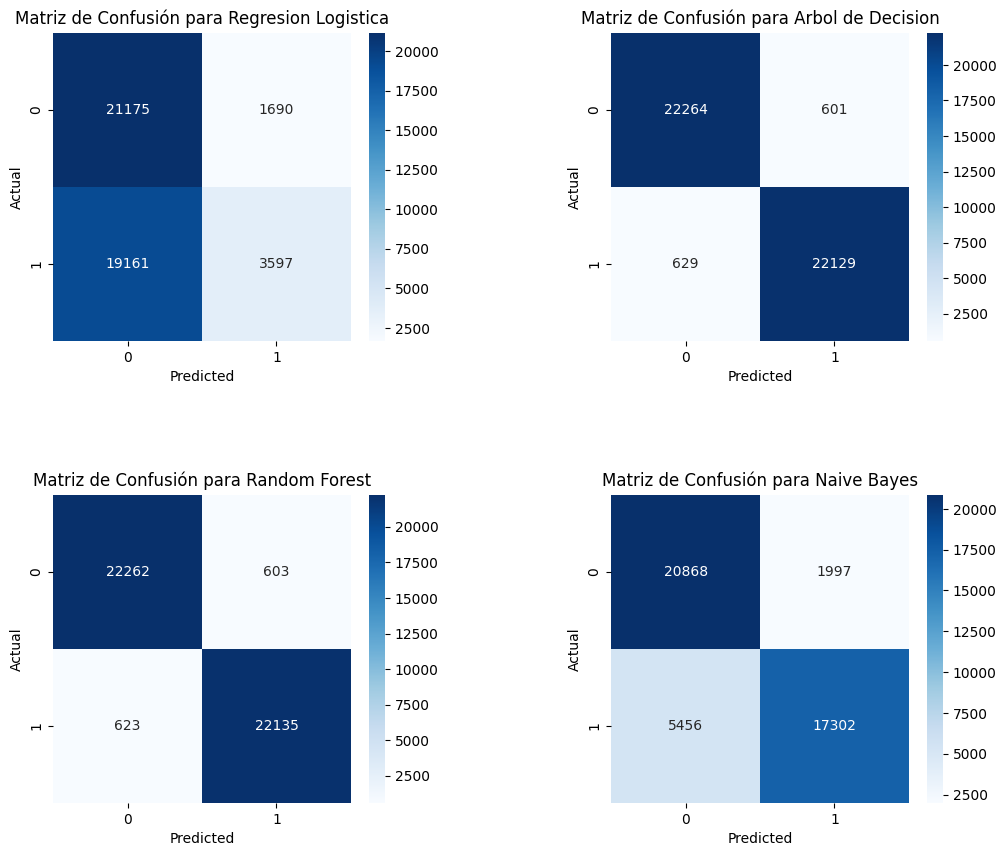

In [79]:
# Uso de la función y visualización de resultados
resultados = crea_modelos(df_balanced)
for i, model in enumerate(resultados['Nombre_Modelo']):
    print(f"Modelo: {model}")
    print(f"Accuracy: {resultados['Accuracy'][i]}")
    print(f"Precisión: {resultados['Precision'][i]}")
    print(f"Recall: {resultados['Recall'][i]}")
    print(f"F1-score: {resultados['F1_Score'][i]}")
    print(f"AUC-ROC: {resultados['AUC_ROC'][i]}\n")

#**5. Evaluación y Selección del Modelo**


---


In [80]:
#@title
def visualiza_resultados():
  global df_banco, resultados
  # Convertir resultados a DataFrame
  df_resultados = pd.DataFrame(resultados)
  # Transponer el DataFrame
  df_resultados = df_resultados.set_index('Nombre_Modelo').T

  # Definir colores para los modelos
  colors = ['#0077b6', '#CDDBF3', '#9370DB', '#DDA0DD']

  # Generar el gráfico de barras
  df_resultados.plot(kind='bar', figsize=(12, 6), colormap='viridis', rot=0, color=colors)
  plt.title('Comparación de Métricas por Modelo')
  plt.xlabel('Métricas')
  plt.ylabel('Puntuación')
  plt.legend(title='Modelos')
  plt.tight_layout()
  plt.show()


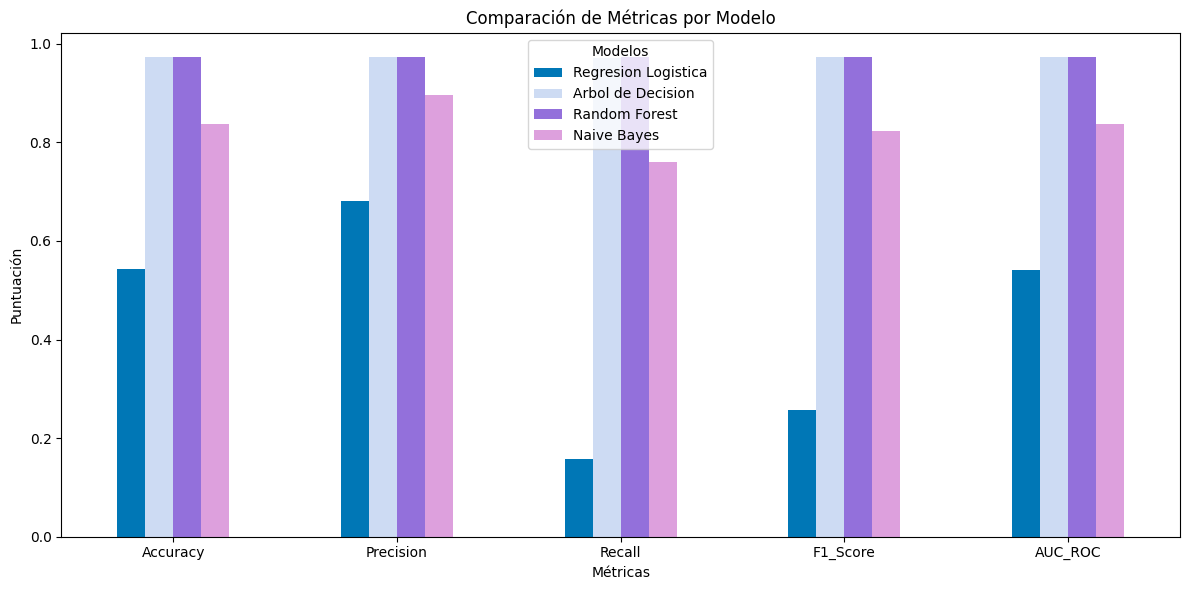

In [55]:
visualiza_resultados()